<a href="https://colab.research.google.com/github/sethschober/Module-4/blob/main/notebooks/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Imports & declarations

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split

import keras
from keras.preprocessing.image import img_to_array, load_img, array_to_img, ImageDataGenerator
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf

LOCAL_PATH_MINI = '../data/raw/kaggle_mini_subsample'
LOCAL_PATH_TRAIN = '../data/raw/train'
COLAB_PATH_TRAIN = '/content/drive/MyDrive/Data Science/Colab Notebooks/Module 4 Project/data/raw/train'
COLAB_PATH_MINI = '/content/drive/MyDrive/Data Science/Colab Notebooks/Module 4 Project/data/raw/mini_subsample'

RANDOM_STATE = 2020

# Comment when running locally, uncomment for Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Define basic functions

In [2]:
def make_flat(x):
    s = x.shape
    dim_0 = s[0]
    dim_1 = s[1]*s[2]*s[3]
    x_flat = x.reshape(dim_0, dim_1)
    shape = (x_flat.shape[1],)
    return x_flat, shape

In [33]:
def plot_results(history, metrics=['accuracy'], val=True):
    
    for metric in metrics:
        x = range(len(history[metric]))

        plt.figure()
        plt.plot(x, history[metric], label='Train')

        if val == True:
            plt.plot(x, history['val_'+metric], label='Validation')
        plt.title(metric)
        plt.legend();

## Mini Dataset

#### Import & Clean

Found 200 images belonging to 2 classes.


'Example image:'

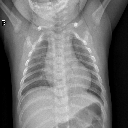

Indices: {'NORMAL': 0, 'PNEUMONIA': 1}
Dataset shape: (200, 128, 128, 3)


In [3]:
BATCH_SIZE = 250
TARGET_SIZE = [128, 128]

path = COLAB_PATH_MINI
image_generator = ImageDataGenerator().flow_from_directory(path, batch_size=BATCH_SIZE, target_size=TARGET_SIZE);
images, labels = next(image_generator)
images_scaled = images / 255

display('Example image:', array_to_img(images[0]))
print('Indices:', image_generator.class_indices)
print('Dataset shape:', images_scaled.shape)

#### Mini Dataset Model

In [4]:
x, shape = make_flat(images_scaled)

model = Sequential()
model.add(Dense(32, activation='relu', input_shape = shape))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x=x, y=labels, epochs=50)

plot_results(history.history, val=False)

model.summary()

Epoch 1/50
7/7 [==============================] - 14s 6ms/step - loss: 0.7183 - accuracy: 0.5104
Epoch 2/50
7/7 [==============================] - 0s 4ms/step - loss: 0.6935 - accuracy: 0.4564
Epoch 3/50
7/7 [==============================] - 0s 4ms/step - loss: 0.6933 - accuracy: 0.4954
Epoch 4/50
7/7 [==============================] - 0s 4ms/step - loss: 0.6934 - accuracy: 0.4861
Epoch 5/50
7/7 [==============================] - 0s 6ms/step - loss: 0.6932 - accuracy: 0.5008
Epoch 6/50
7/7 [==============================] - 0s 5ms/step - loss: 0.6930 - accuracy: 0.5226
Epoch 7/50
7/7 [==============================] - 0s 5ms/step - loss: 0.6928 - accuracy: 0.5327
Epoch 8/50
7/7 [==============================] - 0s 5ms/step - loss: 0.6931 - accuracy: 0.5046
Epoch 9/50
7/7 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5032
Epoch 10/50
7/7 [==============================] - 0s 5ms/step - loss: 0.6932 - accuracy: 0.5005
Epoch 11/50
7/7 [=====================

## Full Dataset

### Import and clean

In [6]:
path = COLAB_PATH_TRAIN
BATCH_SIZE = 32
data_tf = tf.keras.preprocessing.image_dataset_from_directory(path, 
                                                image_size=(256, 256), # WORKS UP TO 256
                                                batch_size=BATCH_SIZE,
                                                seed=RANDOM_STATE)

for i, item in enumerate(data_tf.as_numpy_iterator()):
    if i == 0:
        images = np.array(item[0])
        labels = np.array(item[1])
    else:
        images = np.concatenate([images, item[0]], axis=0)
        labels = np.concatenate([labels, item[1]], axis=0)
        if i % 10 == 0:
            print(int(i/(5232/BATCH_SIZE)*100), '%')

images /= 256

labels_inverted = np.array([0 if i == 1 else 1 for i in labels])
labels = np.concatenate([labels_inverted.reshape(-1,1), labels.reshape(-1,1)], axis=1)

data_tf = None # clear RAM
print('Data shape:', images.shape)
print('Label shape:', labels.shape)

Found 5232 files belonging to 2 classes.
6 %
12 %
18 %
24 %
30 %
36 %
42 %
48 %
55 %
61 %
67 %
73 %
79 %
85 %
91 %
97 %
Data shape: (5232, 256, 256, 3)
Label shape: (5232, 2)


In [7]:
# BATCH_SIZE_TRAIN = 1341+3875
# TARGET_SIZE = [256, 256]

# path = COLAB_PATH_TRAIN

# t0 = time.time()
# generator = ImageDataGenerator().flow_from_directory(path,
#                                                      #batch_size=BATCH_SIZE_TRAIN,
#                                                      target_size=TARGET_SIZE)

# images, labels = next(generator)
# images = images / 256
# t1 = time.time()

# print('Runtime:', t1-t0)
# print(images.shape, labels.shape)

### Baseline Model

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 10)                1966090   
_________________________________________________________________
dense_13 (Dense)             (None, 2)                 22        
Total params: 1,966,112
Trainable params: 1,966,112
Non-trainable params: 0
_________________________________________________________________


None

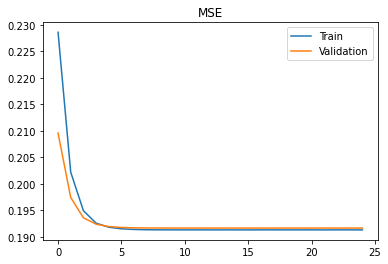

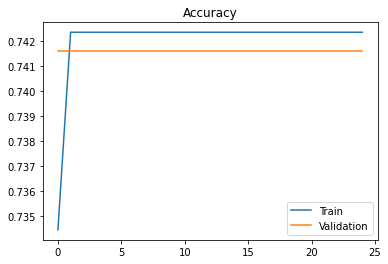

In [23]:
EPOCHS = 25
x, shape = make_flat(images)

model = Sequential()
model.add(Dense(10, activation='relu', input_shape = shape))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')


history = model.fit(x=x, y=labels, 
                    epochs=EPOCHS, 
                    verbose=0,
                    validation_split=0.25)

display(model.summary())


plot_results(history.history, ['accuracy', 'mse'])

# plt.plot(range(EPOCHS), history.history['mse'], label='Train')
# plt.plot(range(EPOCHS), history.history['val_mse'], label='Validation')
# plt.title('MSE')
# plt.legend();

# plt.figure()
# plt.plot(range(EPOCHS), history.history['accuracy'], label='Train')
# plt.plot(range(EPOCHS), history.history['val_accuracy'], label='Validation')
# plt.title('Accuracy')
# plt.legend();

### Define Early Stopping

In [24]:
early_stopping = [EarlyStopping(monitor='val_loss', patience=10),
                 ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)]

### Entire train dataset, validation split

##### Create and fit model

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 32)                6291488   
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 66        
Total params: 6,291,554
Trainable params: 6,291,554
Non-trainable params: 0
_________________________________________________________________


None

ValueError: ignored

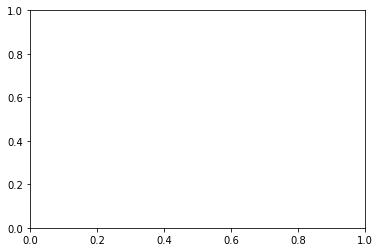

In [27]:
EPOCHS = 200
x, shape = make_flat(images)

model = Sequential()
model.add(Dense(32, activation='relu', input_shape = shape))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy', 'mse'])


history = model.fit(x=x, y=labels, 
                    callbacks = early_stopping,
                    epochs=EPOCHS, 
                    validation_split=0.25, 
                    verbose=0)

best_model = keras.models.load_model('best_model.h5')
display(best_model.summary())

plot_results(history.history, ['accuracy', 'mse'])

# plt.plot(range(EPOCHS), history.history['mse'], label='Train')
# plt.plot(range(EPOCHS), history.history['val_mse'], label='Validation')
# plt.title('MSE')
# plt.legend();

# plt.figure()
# plt.plot(range(EPOCHS), history.history['accuracy'], label='Train')
# plt.plot(range(EPOCHS), history.history['val_accuracy'], label='Validation')
# plt.title('Accuracy')
# plt.legend();

### Create balanced dataset

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(images, labels, 
                                                  random_state=RANDOM_STATE, 
                                                  test_size = 0.25)
images = None # clear memory

In [ ]:
x_train.shape

In [ ]:
# Oversample the minority class: 
# https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#oversample_the_minority_class
np.random.seed(RANDOM_STATE)


ind_neg = y_train[:, 0]==1
ind_pos = y_train[:, 0]==0

neg_ct = ind_neg.sum()
pos_ct = ind_pos.sum()
print('NORMAL count:', neg_ct, ', PNEUMONIA count:', pos_ct)

ids = np.arange(neg_ct)

# Select random entries from the list of inputs
ind_add_ons = np.random.choice(ids, size=pos_ct-neg_ct)
add_ons_x = x_train[ind_neg][ind_add_ons]
add_ons_y = y_train[ind_neg][ind_add_ons]

x_train_balanced = np.concatenate([x_train, add_ons_x], axis=0)
y_train_balanced = np.concatenate([y_train, add_ons_y], axis=0)
print('Training sizes after resampling:', x_train_balanced.shape, y_train_balanced.shape)
print('NORMAL count, PNEUMONIA count:', y_train_balanced.sum(axis=0))

# clear memory
x_train = None
y_train = None

### Create model with resampled dataset

In [ ]:
x_train_flat, shape = make_flat(x_train_balanced)
x_val_flat, _ = make_flat(x_val)

model = Sequential()
model.add(Dense(8, activation='relu', input_shape = shape))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy', 'mse'])

In [ ]:
history = model.fit(x=x_train_flat, y=y_train_balanced, 
                    epochs=50, 
                    validation_data=(x_val_flat, y_val))

plot_results(history.history, ['accuracy', 'mse'])

model.summary()

### Add Regularization

In [ ]:
LAMBDA = 0.005

model = Sequential()
model.add(Dense(256, activation='relu', input_shape = shape, kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dense(2, activation='softmax'))
model.compile(optimizer='SGD', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')

history = model.fit(x=x_train_flat, y=y_train_balanced, 
                    callbacks=early_stopping, 
                    epochs=250, 
                    validation_data=(x_val_flat, y_val))

plot_results(history.history, ['accuracy', 'mse'])

best_model = keras.models.load_model('best_model.h5')
best_model.summary()

### Add Dropout

In [ ]:
x_train_flat, shape = make_flat(x_train_balanced)
x_val_flat, _ = make_flat(x_val)
early_stopping = [EarlyStopping(monitor='val_loss', patience=10),
                 ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)]

LAMBDA = 0.005
DROPOUT = 0.3

t0 = time.time()


model = Sequential()
model.add(Dense(256, activation='relu', input_shape = shape, kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')

history = model.fit(x=x_train_flat, y=y_train_balanced, 
                    callbacks=early_stopping, 
                    epochs=250, 
                    validation_data=(x_val_flat, y_val), verbose=2)

plot_results(history.history, ['accuracy', 'mse'])

best_model = keras.models.load_model('best_model.h5')
best_model.summary()

print('Full runtime:', time.time() - t0)

### Remove the layer of 256 notes from previous model

In [ ]:
x_train_flat, shape = make_flat(x_train_balanced)
x_val_flat, _ = make_flat(x_val)
early_stopping = [EarlyStopping(monitor='val_loss', patience=10),
                 ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)]

LAMBDA = 0.005
DROPOUT = 0.3

t0 = time.time()

model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(LAMBDA)))
model.add(Dropout(DROPOUT))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer='SGD', metrics=['accuracy', 'mse'], loss='categorical_crossentropy')

history = model.fit(x=x_train_flat, y=y_train_balanced, 
                    callbacks=early_stopping, 
                    epochs=250, 
                    validation_data=(x_val_flat, y_val), verbose=2)

plot_results(history.history, ['accuracy', 'mse'])

best_model = keras.models.load_model('best_model.h5')
best_model.summary()

print('Full runtime:', time.time() - t0)